In [ ]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/OneDrive/Documents/Injury Dataset/2013-2022/2018-2022 Data Cleaned Trainable.csv')
data = pd.DataFrame(dataset.iloc[:,:22])
print(data.STATE)

X = pd.DataFrame(dataset.iloc[:,:22].values)
Y = pd.DataFrame(dataset.iloc[:,22:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(Y_train.shape)

In [ ]:
features = pd.DataFrame(dataset.iloc[:,:32])
features = features.columns
print(features)

In [ ]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, GRU, LayerNormalization, MultiHeadAttention,TimeDistributed, Input, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier 

In [ ]:
model = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state=0)
model.fit(X_train, Y_train)

In [ ]:
res = model.predict(X_test)
print(res)
print(Y_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test,res)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,res,digits=6))

In [ ]:
import shap 
explainer = shap.Explainer(model.predict,X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test,feature_names = features,plot_size=(20,15),plot_type="bar",show=False)

In [ ]:
explanation = shap.Explanation(
    values=shap_values, 
    feature_names=features
)
shap.plots.beeswarm(explanation)

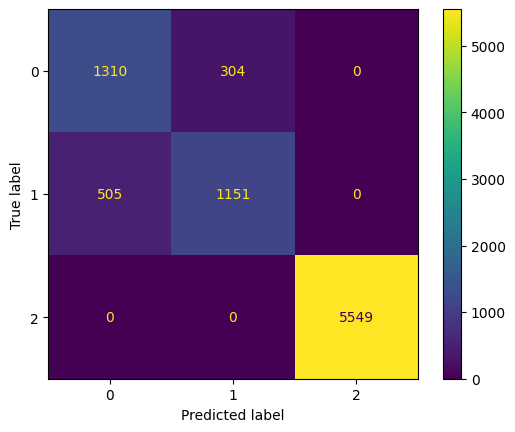

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, res)
cm_display = ConfusionMatrixDisplay(confusionmatrix)
cm_display.plot()